Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!gdown 1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs





Downloading...
From (original): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=6ca2c46b-b5dc-430d-9cdd-8c95fad41024
To: /content/CNN_assignment.zip
100% 824M/824M [00:12<00:00, 67.9MB/s]


In [4]:
!unzip CNN_assignment.zip -d /content/data/

Archive:  CNN_assignment.zip
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: /content/data/Skin cancer ISIC The Intern

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
#data_dir_test = pathlib.Path("/content/gdrive/MyDrive/AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

data_dir_train = pathlib.Path("/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test")



In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [7]:
#load the images using keras preprocessing
train = keras.preprocessing.image_dataset_from_directory(data_dir_train)
test = keras.preprocessing.image_dataset_from_directory(data_dir_test)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.


### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Create dataset with training and validation split of 80:20

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels ='inferred', color_mode ='rgb',
                                                            batch_size = batch_size, image_size = (img_height, img_width),
                                                            seed=123, validation_split = 0.2, subset = 'both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# We can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
Visualise data based on classes from given dataset

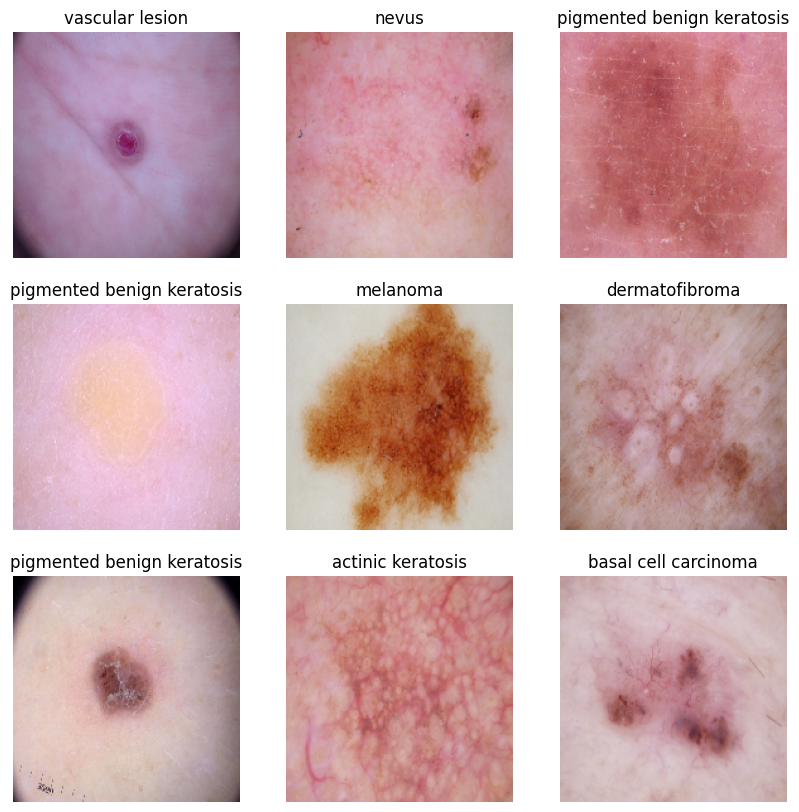

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling((1./255), input_shape=(img_height, img_width, 3)),  # Changed from tf.keras.layers.experimental.preprocessing.Rescaling
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:

model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.1882 - loss: 2.1793 - val_accuracy: 0.3378 - val_loss: 1.8737
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3323 - loss: 1.8299 - val_accuracy: 0.4474 - val_loss: 1.5622
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4537 - loss: 1.5657 - val_accuracy: 0.4787 - val_loss: 1.5532
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5378 - loss: 1.3414 - val_accuracy: 0.5213 - val_loss: 1.4501
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5323 - loss: 1.3086 - val_accuracy: 0.5011 - val_loss: 1.4638
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5829 - loss: 1.1791 - val_accuracy: 0.5593 - val_loss: 1.4578
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6136 - loss: 1.0915 - val_accuracy: 0.5280 - val_loss: 1.4031
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6257 - loss: 1.0232 - val_accuracy: 0.5190 - 

### Visualizing training results

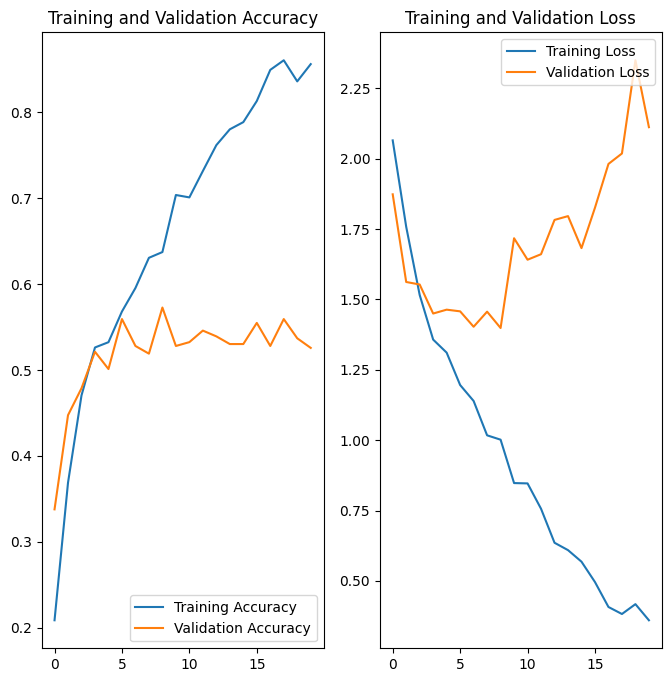

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Key Observations:

Accuracy: The training accuracy steadily increases, reaching a high value, while the validation accuracy also increases but plateaus at a lower value. This suggests that the model is overfitting.
Loss: The training loss decreases significantly, indicating that the model is learning the training data well. However, the validation loss also decreases initially but then starts to increase again. This further supports the overfitting hypothesis.
Overall, the model appears to be overfitting the training data. This means it is learning the training data too well and is not able to generalize well to new, unseen data.



In [19]:
#Data Augmentation: Increasing the size and diversity of the training data can help the model generalize better.

rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)])

# Updated data_augmentation to use tf.keras.layers.preprocessing directly:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])


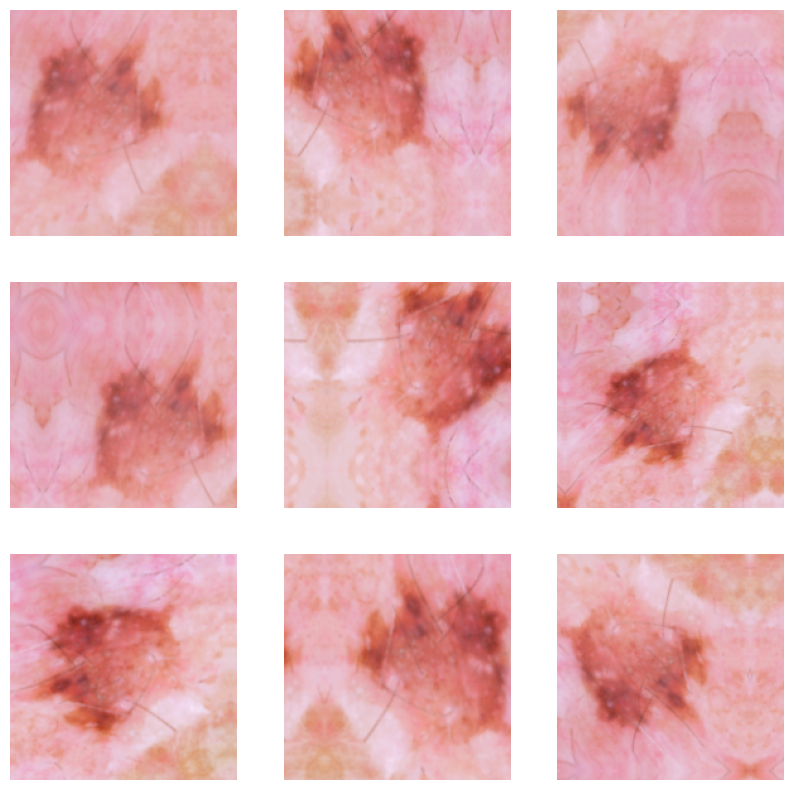

In [20]:
#Visualise the results

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Model 2: Using dropout to fix overfitting

In [21]:
#using the dropout layers to overcome the overfitting


## Model 2 Creation

model2 = Sequential([
    data_augmentation,  # Augmentation layer
    rescale,            # Rescaling layer

    # First Convolutional Block
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Second Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Third Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the tensors

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),  # Dropout with 50%

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Softmax for probabilities
])

### Compiling the model

In [22]:

model2.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1677 - loss: 2.3065 - val_accuracy: 0.2662 - val_loss: 1.9767
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3050 - loss: 1.8651 - val_accuracy: 0.4116 - val_loss: 1.6780
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3883 - loss: 1.7085 - val_accuracy: 0.4183 - val_loss: 1.6576
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3935 - loss: 1.6480 - val_accuracy: 0.4340 - val_loss: 1.5686
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4042 - loss: 1.6355 - val_accuracy: 0.4385 - val_loss: 1.5487
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4161 - loss: 1.6126 - val_accuracy: 0.4631 - val_loss: 1.4822
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4784 - loss: 1.5008 - val_accuracy: 0.3803 - val_loss: 1.6393
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4539 - loss: 1.5257 - val_accuracy: 0.4765 - val_loss: 1.

### Visualizing the results

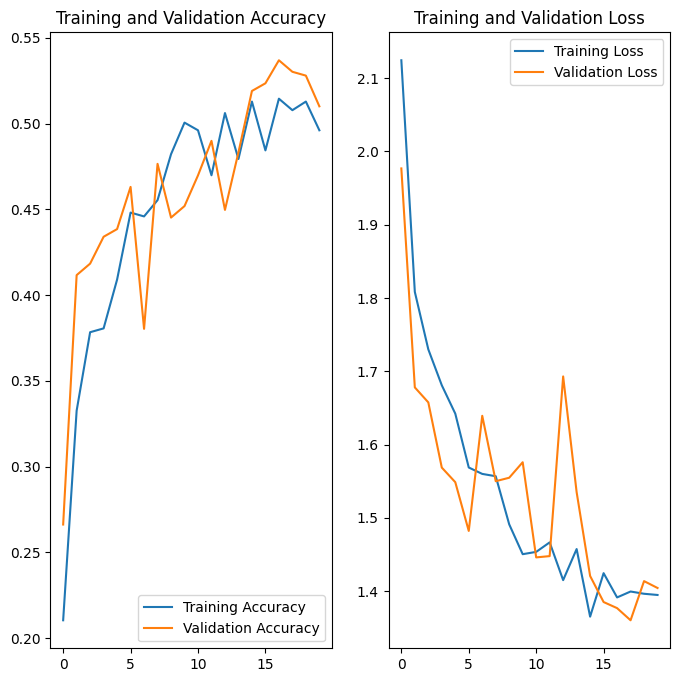

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations:
Accuracy:
The training and validation accuracy are steadily improving and closely aligned throughout the epochs.
No significant divergence is observed, indicating no overfitting.
Loss:
Both training and validation loss decrease over the epochs and remain fairly consistent.
The validation loss slightly increases toward the end, which might suggest the model is slightly overfitting as it continues to learn the training data.
Conclusion:
There is no clear evidence of severe overfitting or underfitting.
The model is well-trained, but monitoring the slight increase in validation loss at the later epochs is recommended.
Further improvements could include adding regularization techniques like dropout or early stopping to fine-tune performance.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
#to find the distribution of the classes in the training data set

# Specify the directory
directory = data_dir_train



# Count the number of images in each class
count = []
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path, name))]))

# Get the names of the classes (subdirectories)
sub_directory = [name for name in os.listdir(directory)
                 if os.path.isdir(os.path.join(directory, name))]

# Create a dataframe with image counts and class names
class_distribution = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

# Display the dataframe
print(class_distribution)


                        Class  No. of Image
0        basal cell carcinoma           376
1             vascular lesion           139
2  pigmented benign keratosis           462
3        seborrheic keratosis            77
4                       nevus           357
5           actinic keratosis           114
6     squamous cell carcinoma           181
7              dermatofibroma            95
8                    melanoma           438


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Class with the least number of samples:

Seborrheic keratosis (77 samples).
Classes dominating the data (in terms of the proportionate number of samples):

Pigmented benign keratosis (462 samples).
Melanoma (438 samples).

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train / i)) # Changed this line
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CA550FE590>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CA550E2830>: 100%|██████████| 500/500 [00:16<00:00, 30.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CA504AA9B0>: 100%|██████████| 500/500 [00:14<00:00, 35.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CA303D3430>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x79CA301919F0>: 100%|██████████| 500/500 [01:07<00:00,  7.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CA5064B280>: 100%|██████████| 500/500 [00:14<00:00, 35.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CA50532170>: 100%|██████████| 500/500 [00:32<00:00, 15.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79CA304E8B50>: 100%|██████████| 500/500 [00:14<00:00, 34.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CA50530910>: 100%|██████████| 500/500 [00:14<00:00, 33.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031095.jpg_8f012dcb-e068-44d9-9946-75aa442d339a.jpg',
 '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028818.jpg_55a2c0a0-34e3-40c5-ae28-88616e5edff9.jpg',
 '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024795.jpg_0faaaec6-f6bf-4ac7-9b2e-d21b1bde3d91.jpg',
 '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026439.jpg_e98a6d45-cfa9-4bde-8f53-adef27f8a523.jpg',
 '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030138.jpg_fefd3f52-395e-4f92-9aff-439d6ebac

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
original_df=pd.DataFrame(columns = ['Path','Label'])
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

,count
Label,
basal cell carcinoma,500
vascular lesion,500
pigmented benign keratosis,500
seborrheic keratosis,500
nevus,500
actinic keratosis,500
squamous cell carcinoma,500
dermatofibroma,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Model 3: Augumented data + Normalization

In [37]:

#creating the model with normalization
# Define the Sequential model
model3 = Sequential([
    rescale,  # Rescaling Layer

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    # Output Layer with Softmax
    layers.Dense(len(class_names), activation='softmax')
])


Compling the model

In [38]:

#compiling the above code
model3.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model

In [39]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.1586 - loss: 2.6586 - val_accuracy: 0.1396 - val_loss: 4.2588
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 144ms/step - accuracy: 0.2934 - loss: 1.9409 - val_accuracy: 0.1982 - val_loss: 2.8936
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.3589 - loss: 1.6888 - val_accuracy: 0.2635 - val_loss: 2.1002
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.4057 - loss: 1.5476 - val_accuracy: 0.4195 - val_loss: 1.5133
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.4576 - loss: 1.4361 - val_accuracy: 0.3994 - val_loss: 1.6004
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.4788 - loss: 1.3807 - val_accuracy: 0.4595 - val_loss: 1.4206
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.4951 - loss: 1.3446 - val_accuracy: 0.4640 - val_loss: 1.3412
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.5026 - loss: 1.2949 - val

Visualize the model results

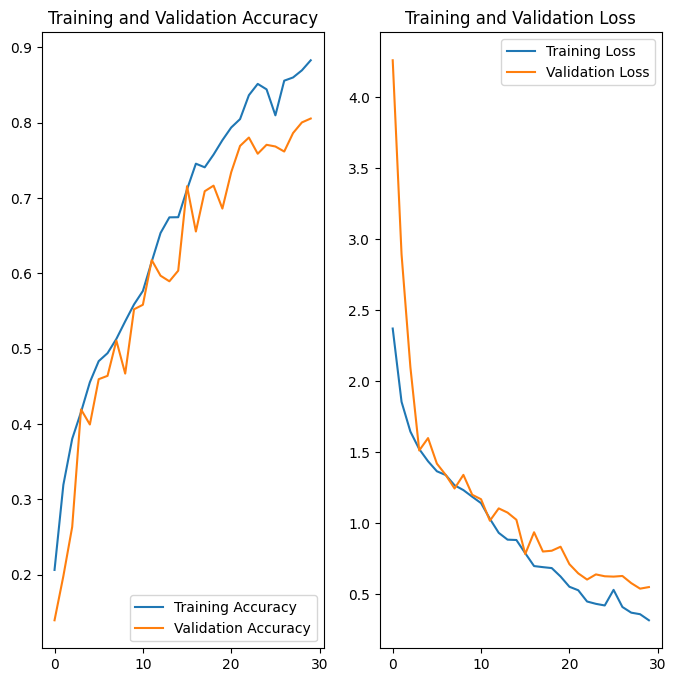

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From Model 3 resu;ts,we can visualise that training and validation results are go hand in hand. Rebalancing with augmentor removed the overfitting problems.

